In [29]:
import matplotlib.colors as mcolors
import matplotlib.animation as ma
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from itertools import product
import pandas as pd
import numpy as np
import numba as nb
import imageio
import os
import shutil

randomSeed = 100

%matplotlib inline
%config InlineBackend.figure_format = "retina"

new_cmap = mcolors.LinearSegmentedColormap.from_list(
    "new", plt.cm.jet(np.linspace(0, 1, 256)) * 0.85, N=256
)

@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - phaseTheta / (2 * np.pi) * 256).astype(np.int32)

import seaborn as sns

sns.set(font_scale=1.1, rc={
    'figure.figsize': (6, 5),
    'axes.facecolor': 'white',
    'figure.facecolor': 'white',
    'grid.color': '#dddddd',
    'grid.linewidth': 0.5,
    "lines.linewidth": 1.5,
    'text.color': '#000000',
    'figure.titleweight': "bold",
    'xtick.color': '#000000',
    'ytick.color': '#000000'
})

plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
if os.path.exists("/opt/conda/bin/ffmpeg"):
    plt.rcParams['animation.ffmpeg_path'] = "/opt/conda/bin/ffmpeg"
else:
    plt.rcParams['animation.ffmpeg_path'] = "D:/Programs/ffmpeg/bin/ffmpeg.exe"

from main import *
from multiprocessing import Pool
import pandas as pd

In [ ]:
### single distribution ring
agnetsCount = 500
rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.01), np.arange(0.1, 0.31, 0.1)
])
distanceDs = np.concatenate([
    np.arange(0.1, 1.1, 0.1)
])

speedV = 0.03
idx = 1

targetPath = "lastStateRing_10.h5"  # lastStateAfter  # lastStateRing  # lastState

totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")

modelNums = totalPositionX.shape[0] // agnetsCount
totalPositionX = totalPositionX.values.reshape(modelNums, agnetsCount, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(modelNums, agnetsCount)
totalPointTheta = totalPointTheta.values.reshape(modelNums, agnetsCount)

idx = 0
positionX = dict()
phaseTheta = dict()
pointTheta = dict()

np.random.seed(10)
omegaTheta = np.concatenate([
    np.random.uniform(1, 3, size=500),
    np.random.uniform(-3, -1, size=500)
])

for l, d0 in product(rangeLambdas, distanceDs):
    
    positionX[f"{l:.3f}_{d0:.2f}"] = totalPositionX[idx]
    phaseTheta[f"{l:.3f}_{d0:.2f}"] = totalPhaseTheta[idx]
    pointTheta[f"{l:.3f}_{d0:.2f}"] = totalPointTheta[idx]

    idx += 1

In [12]:
@nb.njit
def colors_idx(phaseTheta):
    return np.floor(256 - (1 - (phaseTheta - 1) / 2) * 256).astype(np.int32)

rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.01), np.arange(0.1, 0.31, 0.1)
])
distanceDs = np.concatenate([
    np.arange(0.1, 1.1, 0.1)
])

idx = 1

fig = plt.figure(figsize=(len(rangeLambdas) * 4.5, len(distanceDs) * 5))

for l, d0 in tqdm(product(rangeLambdas, distanceDs), total=len(rangeLambdas) * len(distanceDs)):
    
    model = SingleDistribution(strengthLambda=l, distanceD0=d0, boundaryLength=5, tqdm=False, savePath="./data", distributType="uniform", randomSeed=10, overWrite=True)
    ax = plt.subplot(len(rangeLambdas), len(distanceDs), idx)
    
    key = f"{l:.3f}_{d0:.2f}"
    # for i in range(1, 6):
    # try:
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    # except:
    #     continue

    omegaTheta = model.omegaTheta
    plt.quiver(
        lastPositionX[:, 0], lastPositionX[:, 1],
        np.cos(lastPhaseTheta[:]), np.sin(lastPhaseTheta[:]), 
        color=[new_cmap(i) for i in colors_idx(omegaTheta)], alpha=0.8
    )
    plt.scatter(lastPositionX[:, 0], lastPositionX[:, 1],
                c=omegaTheta, cmap=new_cmap, alpha=0.8, vmin=1, vmax=3, s=0.01)
    # print(min(phaseTheta + np.pi), max(phaseTheta + np.pi))
    cbar = plt.colorbar(ticks=[1, 2, 3])
    cbar.ax.set_ylim(1, 3)
    cbar.ax.set_yticklabels(['$1$', '$2$', '$3$'])
    # ax.quiver(
    #     positionX[class2, 0], positionX[class2, 1],
    #     np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
    # )
    ax.set_xlim(0, 5)
    ax.set_ylim(0, 5)    
    ax.set_title(f"{l:.3f}_{d0:.2f}")
    
    idx += 1

plt.savefig("SingleDistributionBigGraph.png", dpi=200, bbox_inches="tight")
plt.close()

  0%|          | 0/120 [00:00<?, ?it/s]

In [10]:
omegaTheta.max()

2.9999796120088145

In [ ]:
fig = plt.figure(figsize=(len(rangeLambdas) * 3, len(distanceDs) * 5))

idx = 1

for l, d0 in tqdm(product(rangeLambdas, distanceDs), total=len(rangeLambdas) * len(distanceDs)):
    
    key = f"{l:.3f}_{d0:.2f}"

    singlePositionX = positionX[key]
    singlePhaseTheta = phaseTheta[key]
    singlePointTheta = pointTheta[key]

    centers = StateAnalysis._calc_centers(singlePositionX, singlePhaseTheta, singlePointTheta, speedV)

    ax = plt.subplot(len(rangeLambdas), len(distanceDs), idx)
    ax.quiver(
        singlePositionX[class1, 0], singlePositionX[class1, 1],
        np.cos(singlePhaseTheta[class1]), np.sin(singlePhaseTheta[class1]), color='tomato', alpha=0.5
    )
    ax.quiver(
        singlePositionX[class2, 0], singlePositionX[class2, 1],
        np.cos(singlePhaseTheta[class2]), np.sin(singlePhaseTheta[class2]), color='dodgerblue', alpha=0.5
    )
    ax.scatter(centers[class1, 0], centers[class1, 1], color="orange", s=5)
    ax.scatter(centers[class2, 0], centers[class2, 1], color="blue", s=5)
    # ax.scatter(centers[:, 0], centers[:, 1], color="green", s=3, alpha=0.7)
    ax.set_xlim(0, 10)
    ax.set_ylim(0, 10)    
    ax.set_title(key)

    idx += 1

# plt.savefig("centorsBigGraph1.png", dpi=200, bbox_inches="tight")
plt.close()

# 旋转半径

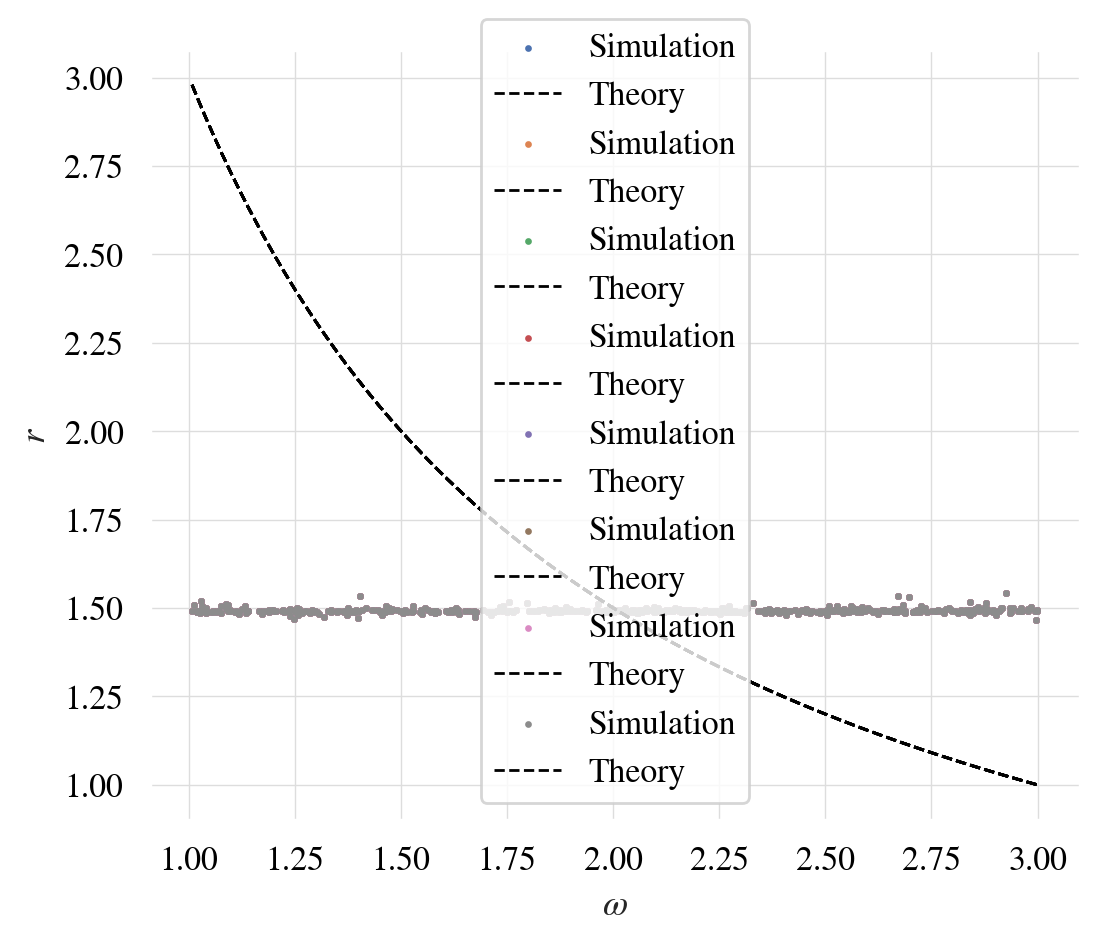

In [18]:
rangeLambdas = np.concatenate([
    np.arange(0.05, 0.1, 0.01), np.arange(0.1, 0.31, 0.1)
])
distanceDs = np.concatenate([
    np.arange(0.1, 1.1, 0.1)
])

for rangeLambda in rangeLambdas:
    
    model = SingleDistribution(strengthLambda=rangeLambda, distanceD0=0.1, boundaryLength=5, 
                               tqdm=False, savePath="./data", distributType="uniform", 
                               randomSeed=10, overWrite=True)
    key = f"{l:.3f}_{d0:.2f}"
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    # positionX, phaseTheta, pointTheta = sa.get_state(-1)
    distances = np.sqrt(np.sum((centers - lastPositionX)**2, axis=1))  # sa.adj_distance(centers, positionX)
    omegaTheta = model.omegaTheta
    sort = np.argsort(omegaTheta)
    omegaTheta, distances = omegaTheta[sort], distances[sort]

    plt.scatter(omegaTheta, distances, label="Simulation", s=2)
    plt.plot(omegaTheta, 3 / omegaTheta, linestyle="--", color="black", lw=1, label="Theory")
    plt.legend()
    plt.xlabel(r"$\omega$")
    plt.ylabel(r"$r$")

# 序参量

## 截面序参量

### 旋转中心邻域内的其余中心数

Text(0, 0.5, '$\\lambda$')

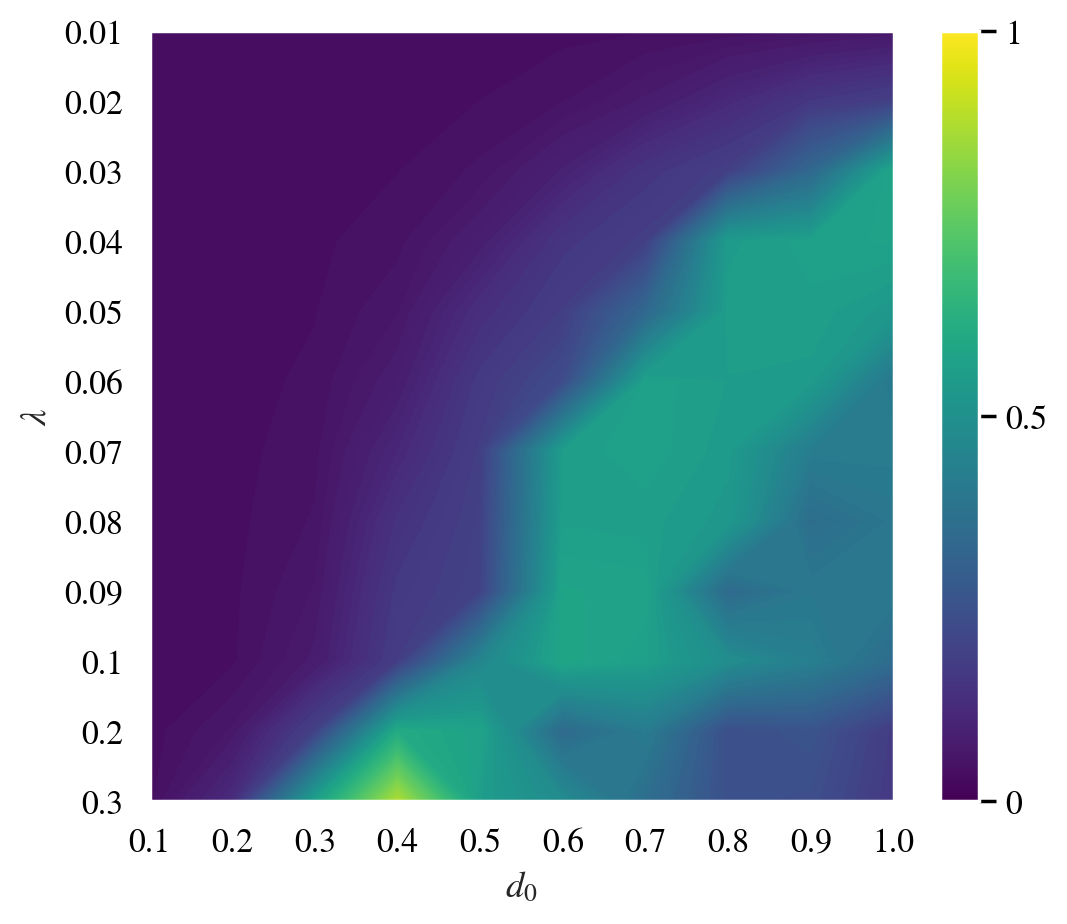

In [12]:
@nb.njit
def _delta_x(positionX, others):
    subX = positionX - others
    adjustOthers = (
        others * (-5 <= subX) * (subX <= 5) + 
        (others - 10) * (subX < -5) + 
        (others + 10) * (subX > 5)
    )
    adjustSubX = positionX - adjustOthers
    return adjustSubX

# @nb.njit
def nearby_nums(centers: np.ndarray):
    deltaX = _delta_x(centers, centers[:, np.newaxis])
    dist = np.sqrt(np.sum(deltaX ** 2, axis=2))
    return np.sum(dist < 1, axis=1)

maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):
    
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)

    maps.loc[l, d0] = np.mean(nearby_nums(centers)) / 500
    
maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)

plt.contourf(
    maps[::-1], levels=100, vmin=0, vmax=1,
    cmap="viridis",
)
plt.scatter(
    np.zeros(maps.shape[0] * maps.shape[1]), np.zeros(maps.shape[0] * maps.shape[1]),
    c=maps.values.flatten()[::-1], cmap="viridis", s=10
)

cbar = plt.colorbar(ticks=[0, 0.5, 1])
cbar.ax.set_ylim(0, 1)
plt.clim(0, 1)
cbar.ax.set_yticklabels(['0', '0.5', '1'])
plt.xticks(np.arange(len(distanceDs)), np.round(distanceDs, 2))
plt.yticks(np.arange(len(rangeLambdas)), np.round(rangeLambdas, 2)[::-1])
plt.ylim(0, maps.shape[0] - 1)
plt.xlim(0, maps.shape[1] - 1)

# sns.heatmap(maps, cmap="viridis_r") # vmax=0.5
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 相位(速度方向)同步率

Text(0, 0.5, '$\\lambda$')

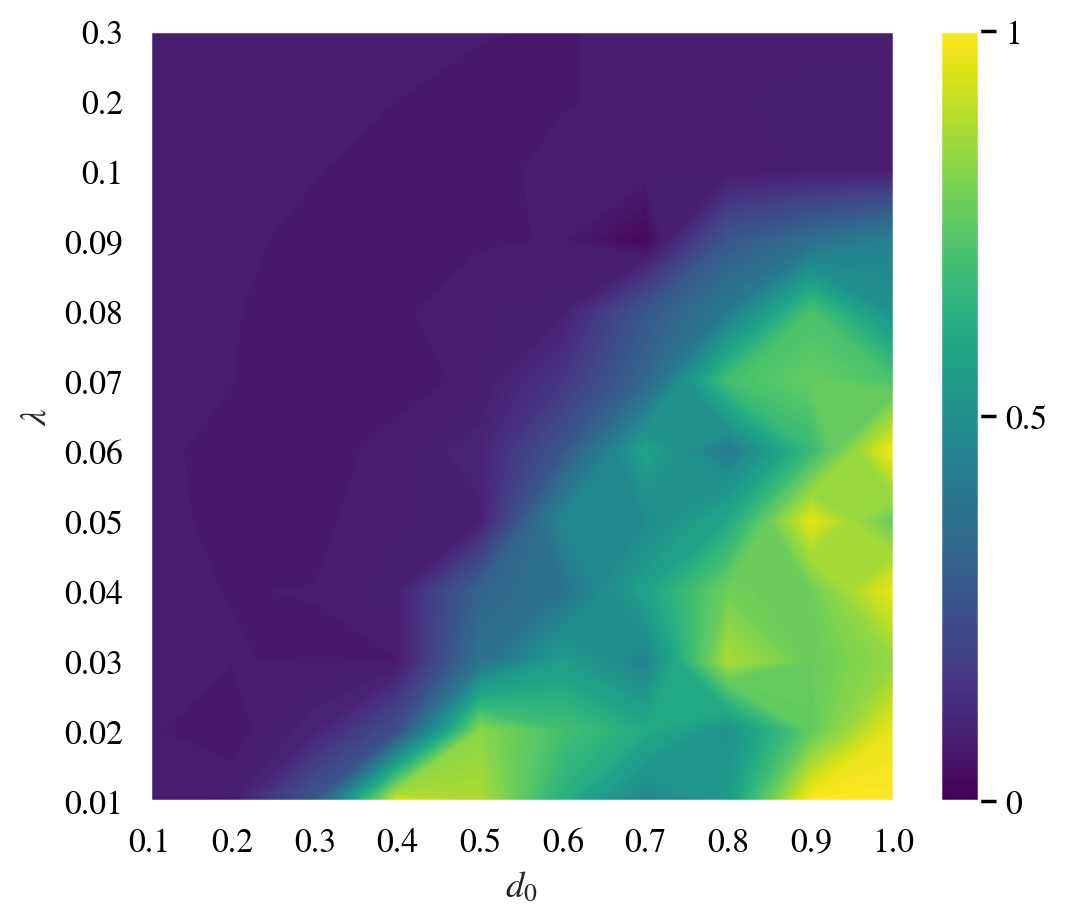

In [40]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    phaseAggOp = StateAnalysis._clac_phase_sync_op(lastPhaseTheta)
    maps.loc[l, d0] = phaseAggOp

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)

plt.contourf(
    maps[::-1], levels=100, vmin=0, vmax=1,
    cmap="viridis",
)
plt.scatter(
    np.zeros(maps.shape[0] * maps.shape[1]), np.zeros(maps.shape[0] * maps.shape[1]),
    c=maps.values.flatten()[::-1], cmap="viridis", s=10
)

cbar = plt.colorbar(ticks=[0, 0.5, 1])
cbar.ax.set_ylim(0, 1)
plt.clim(0, 1)
cbar.ax.set_yticklabels(['0', '0.5', '1'])
plt.xticks(np.arange(len(distanceDs)), np.round(distanceDs, 2))
plt.yticks(np.arange(len(rangeLambdas)), np.round(rangeLambdas, 2))
plt.ylim(0, maps.shape[0] - 1)
plt.xlim(0, maps.shape[1] - 1)

# sns.heatmap(maps, cmap="viridis_r") # vmax=0.5
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 旋转中心空间聚集程度1

Text(0, 0.5, '$\\lambda$')

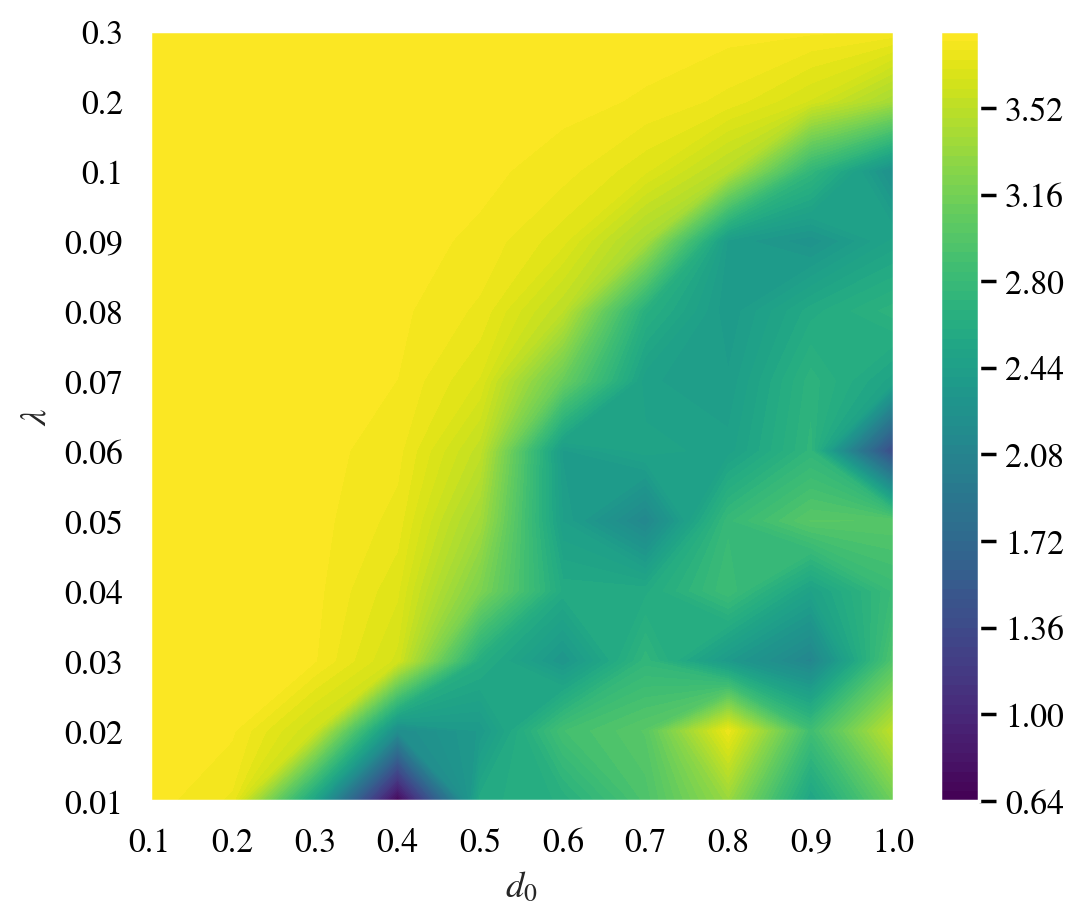

In [45]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    deltaX = _delta_x(centers, centers[:, np.newaxis])
    centerAggOp = np.sqrt(np.sum(deltaX ** 2, axis=2)).mean(axis=1)
    
    maps.loc[l, d0] = np.mean(centerAggOp)

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
plt.contourf(
    maps[::-1], levels=100,
    cmap="viridis",
)

cbar = plt.colorbar()
# cbar.ax.set_ylim(0, 1)
# plt.clim(0, 1)
# cbar.ax.set_yticklabels(['0', '0.5', '1'])
plt.xticks(np.arange(len(distanceDs)), np.round(distanceDs, 2))
plt.yticks(np.arange(len(rangeLambdas)), np.round(rangeLambdas, 2))
plt.ylim(0, maps.shape[0] - 1)
plt.xlim(0, maps.shape[1] - 1)

# sns.heatmap(maps, cmap="viridis_r") # vmax=0.5
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 旋转中心空间聚集程度2

Text(40.234375, 0.5, '$\\lambda$')

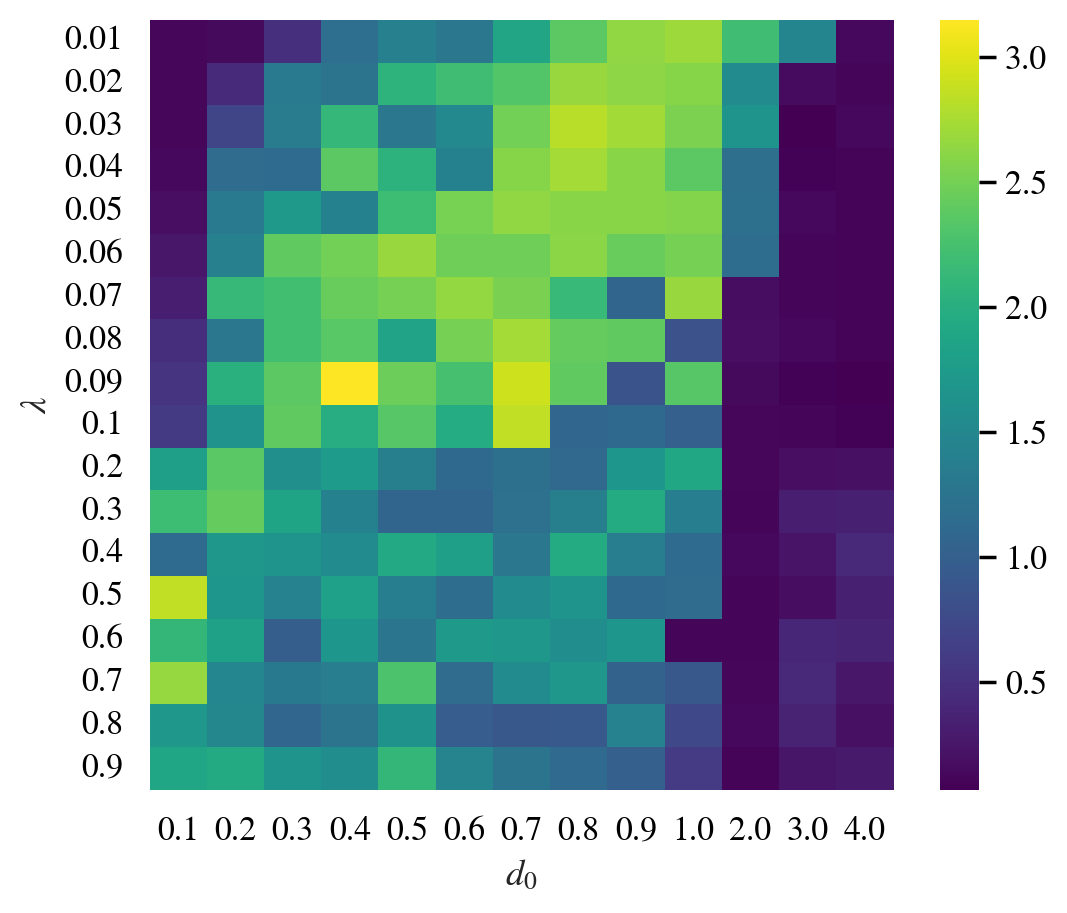

In [144]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    deltaX = _delta_x(centers, centers[:, np.newaxis])
    centerAggOp = np.sqrt(np.sum(deltaX.mean(axis=1) ** 2, axis=-1))
    
    maps.loc[l, d0] = np.mean(centerAggOp)

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
sns.heatmap(maps, cmap="viridis")
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 粒子空间聚集程度2

Text(40.234375, 0.5, '$\\lambda$')

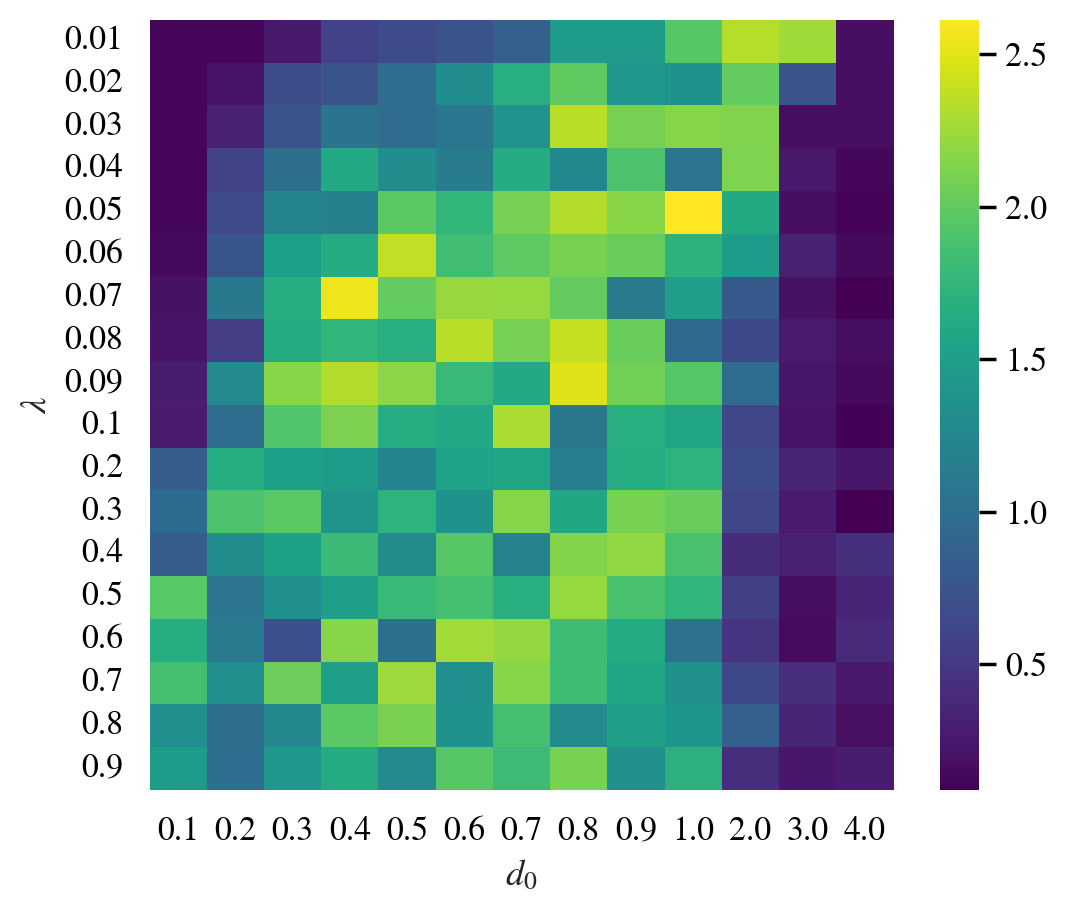

In [37]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    deltaX = _delta_x(lastPositionX, lastPositionX[:, np.newaxis])
    centerAggOp = np.sqrt(np.sum(deltaX.mean(axis=1) ** 2, axis=-1))
    
    maps.loc[l, d0] = np.mean(centerAggOp)

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
sns.heatmap(maps, cmap="viridis")
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 粒子空间距离标准差

Text(40.234375, 0.5, '$\\lambda$')

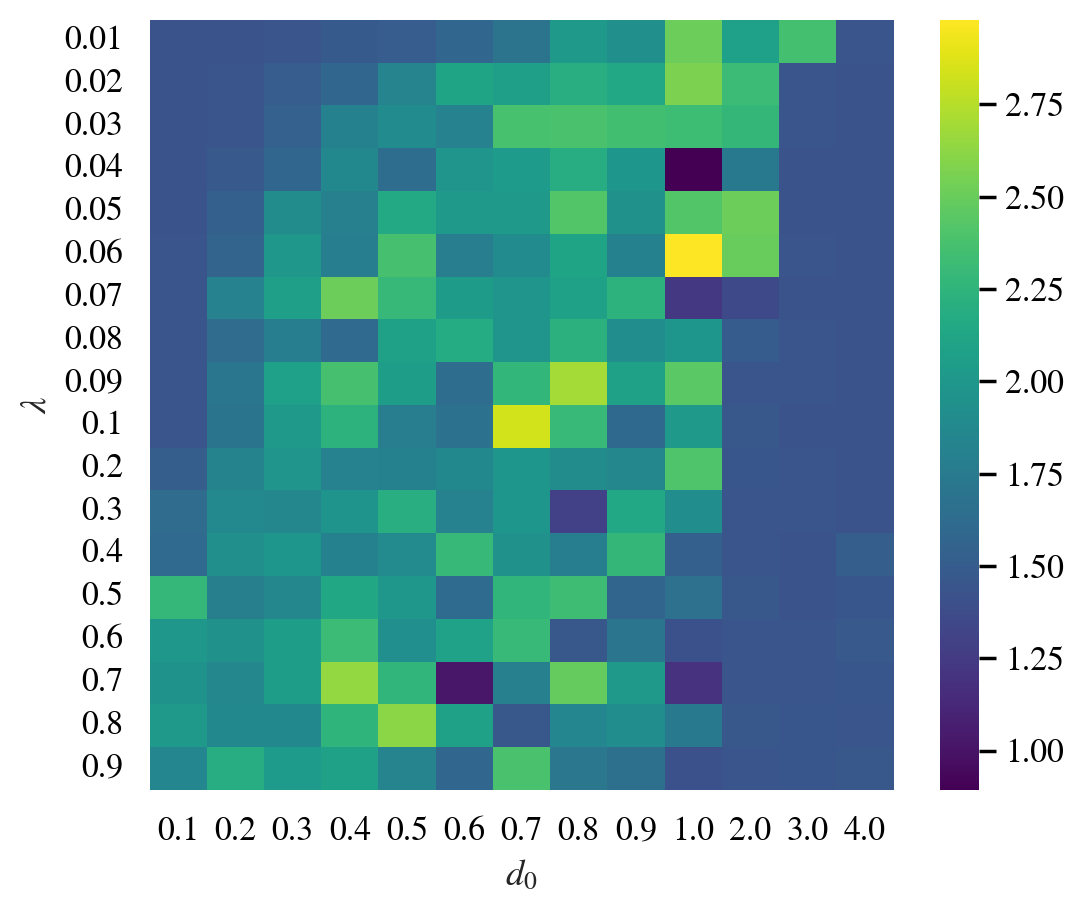

In [43]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    deltaX = _delta_x(lastPositionX, lastPositionX[:, np.newaxis])
    centerAggOp = np.sqrt(np.sum(deltaX ** 2, axis=-1))
    # assert 0
    maps.loc[l, d0] = np.std(centerAggOp)

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
sns.heatmap(maps, cmap="viridis")
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 聚类平均相位同步程度

Text(0, 0.5, '$\\lambda$')

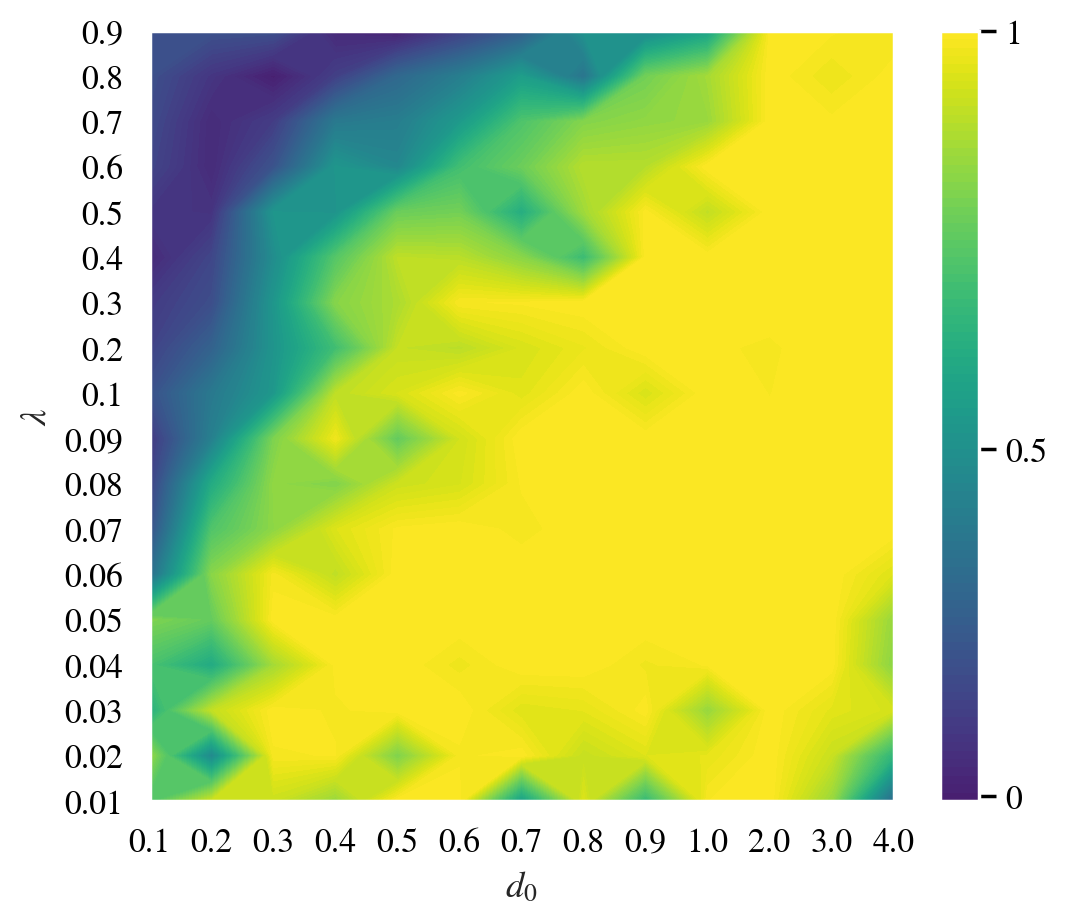

In [22]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    classes = StateAnalysis._calc_classes(
        centers, 1, 
        StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    )
    counts = 0
    sumR = 0
    for classOcsis in classes:
        if len(classOcsis) < 5:
            continue
        sumR += StateAnalysis._clac_phase_sync_op(lastPhaseTheta[classOcsis])
        counts += 1
    
    maps.loc[l, d0] = sumR / counts

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
plt.contourf(
    maps[::-1], levels=100, vmin=0, vmax=1,
    cmap="viridis",
)
cbar = plt.colorbar(ticks=[np.min(maps.values), 0.5, 1])
cbar.ax.set_yticklabels(['0', '0.5', '1'])
plt.xticks(np.arange(len(distanceDs)), np.round(distanceDs, 2))
plt.yticks(np.arange(len(rangeLambdas)), np.round(rangeLambdas, 2))
# sns.heatmap(maps, cmap="viridis_r") # vmax=0.5
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 聚类平均距离方差

Text(40.234375, 0.5, '$\\lambda$')

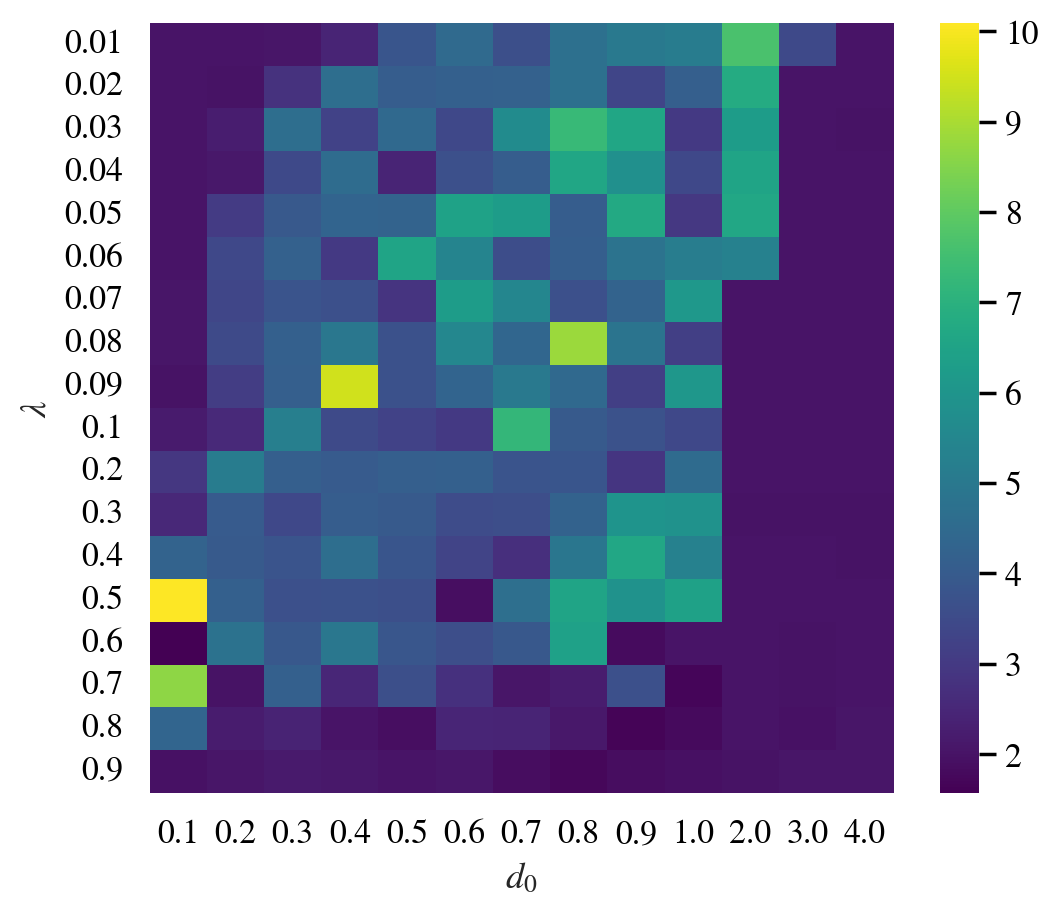

In [41]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    distances = StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    classes = StateAnalysis._calc_classes(centers, 1, distances)
    counts = 0
    sumR = 0
    for classOcsis in classes:
        # if len(classOcsis) < 5:
        #     continue
        classDis = distances[classOcsis]
        sumR += np.var(classDis[classDis != 0])
        counts += 1
    
    maps.loc[l, d0] = sumR / counts

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
sns.heatmap(maps, cmap="viridis")
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 聚类数

Text(0, 0.5, '$\\lambda$')

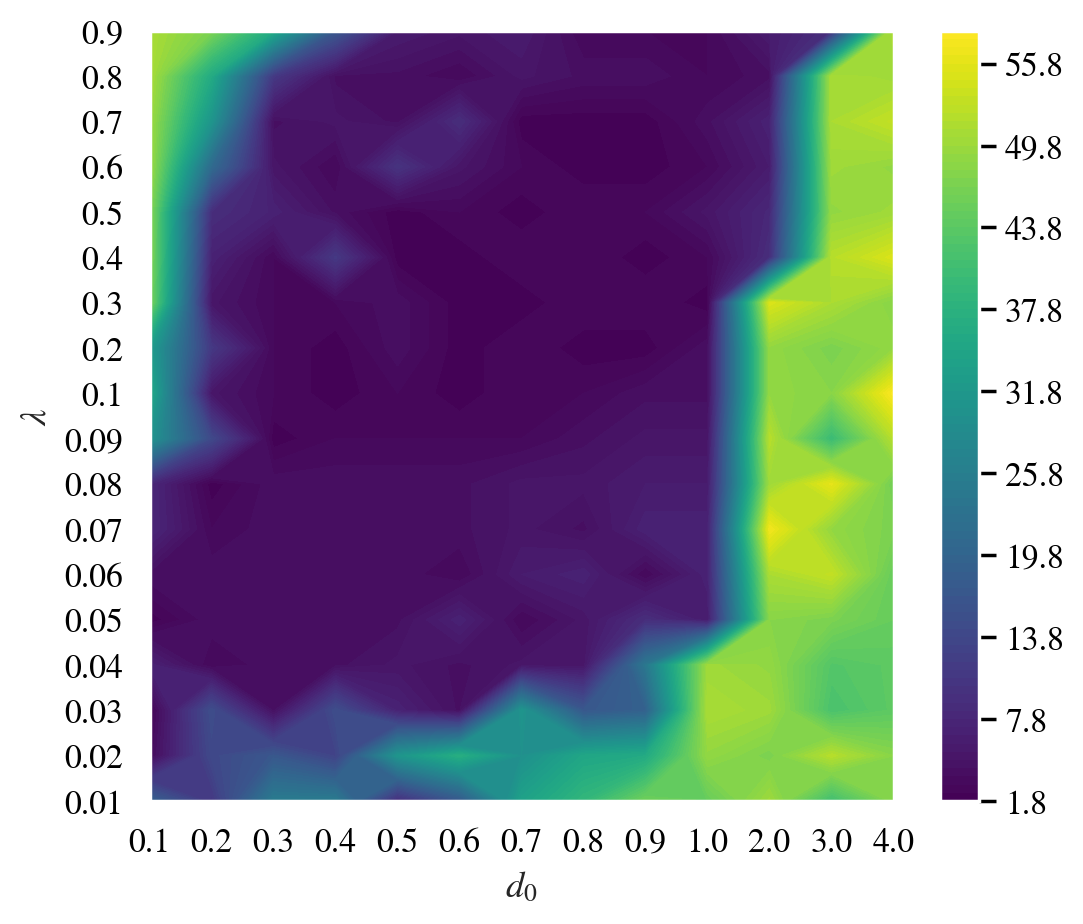

In [25]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    classes = StateAnalysis._calc_classes(
        centers, 0.8, 
        StateAnalysis._adj_distance(centers, centers[:, np.newaxis], 10, 5)
    )
    
    maps.loc[l, d0] = len(classes)

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
plt.contourf(
    maps[::-1], levels=100,
    cmap="viridis",
)
cbar = plt.colorbar()
# cbar.ax.set_yticklabels(['0', '0.5', '1'])
plt.xticks(np.arange(len(distanceDs)), np.round(distanceDs, 2))
plt.yticks(np.arange(len(rangeLambdas)), np.round(rangeLambdas, 2))
# sns.heatmap(maps, cmap="viridis_r") # vmax=0.5
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 中心距离倒数加权相位同步程度

d:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == "":


Text(40.234375, 0.5, '$\\lambda$')

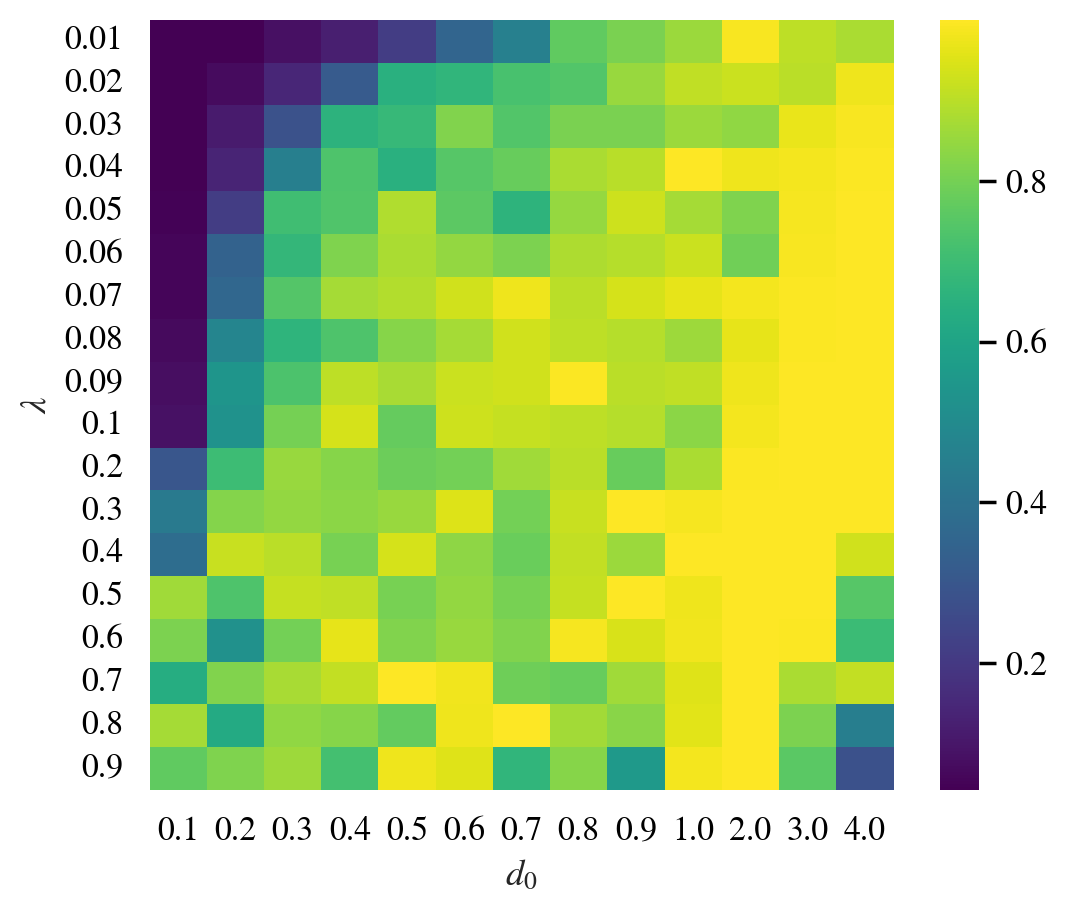

In [7]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    deltaX = _delta_x(centers, centers[:, np.newaxis])
    centerDisMat = 1 / np.sqrt(np.sum(deltaX ** 2, axis=-1))
    centerDisMat[np.isinf(centerDisMat)] = 0
    # rowWgtPhase = lastPhaseTheta * centerDisMat / centerDisMat.sum(axis=0)
    N = centers.shape[0]
    phaseSyncs = [
        (
            (np.sum(np.sin(lastPhaseTheta) * centerDisMat[rowIdx]) / centerDisMat[rowIdx].sum()) ** 2 + 
            (np.sum(np.cos(lastPhaseTheta) * centerDisMat[rowIdx]) / centerDisMat[rowIdx].sum()) ** 2
        )**0.5
        for rowIdx in range(N)
    ]
    maps.loc[l, d0] = np.mean(phaseSyncs)

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
sns.heatmap(maps, cmap="viridis")
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 旋转中心邻域内中心数

Text(40.234375, 0.5, '$\\lambda$')

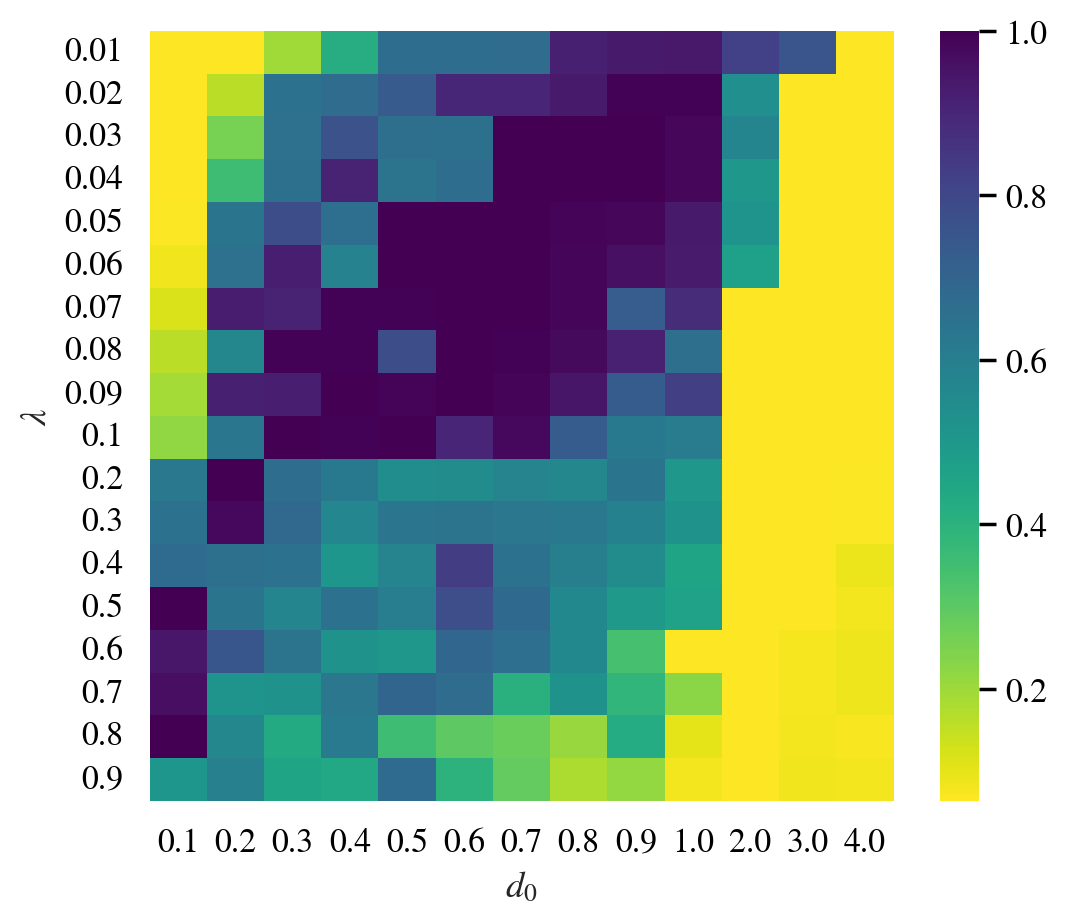

In [5]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    deltaX = _delta_x(centers, centers[:, np.newaxis])
    distanceMat = np.sqrt(np.sum(deltaX ** 2, axis=-1))
    centerDisMat = distanceMat < 1

    maps.loc[l, d0] = centerDisMat.sum(axis=1).mean() / 500

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
sns.heatmap(maps, cmap="viridis_r")
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 旋转中心邻域内相位同步程度

Text(0, 0.5, '$\\lambda$')

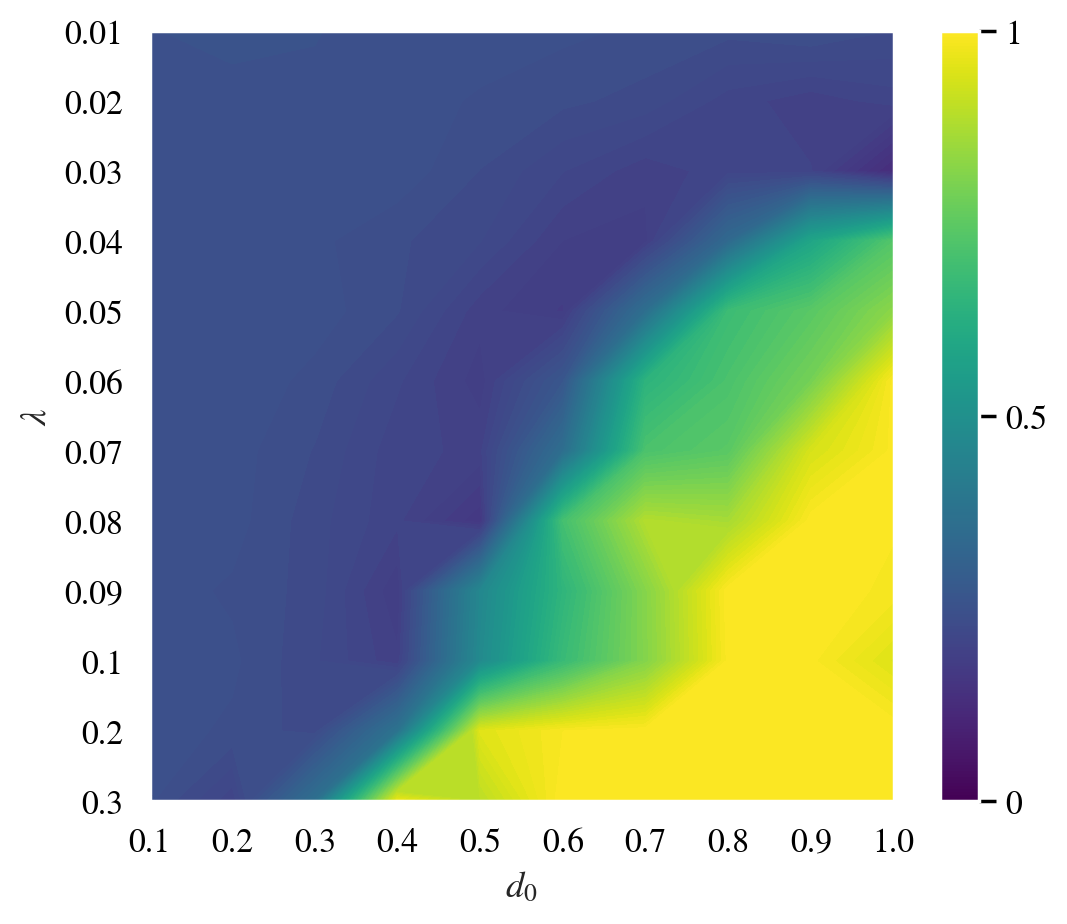

In [33]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centers = np.mod(centers, 10)
    deltaX = _delta_x(centers, centers[:, np.newaxis])
    distanceMat = np.sqrt(np.sum(deltaX ** 2, axis=-1))
    centerDisMat = distanceMat < 1
    # rowWgtPhase = lastPhaseTheta * centerDisMat / centerDisMat.sum(axis=0)
    N = centers.shape[0]
    phaseSyncs = [
        (
            (np.sum(np.sin(lastPhaseTheta) * centerDisMat[rowIdx]) / centerDisMat[rowIdx].sum()) ** 2 + 
            (np.sum(np.cos(lastPhaseTheta) * centerDisMat[rowIdx]) / centerDisMat[rowIdx].sum()) ** 2
        )**0.5
        for rowIdx in range(N)
    ]
    maps.loc[l, d0] = np.mean(phaseSyncs)

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)

plt.contourf(
    maps[::-1], levels=100, vmin=0, vmax=1,
    cmap="viridis",
)
plt.scatter(
    np.zeros(maps.shape[0] * maps.shape[1]), np.zeros(maps.shape[0] * maps.shape[1]),
    c=maps.values.flatten()[::-1], cmap="viridis", s=10
)

cbar = plt.colorbar(ticks=[0, 0.5, 1])
cbar.ax.set_ylim(0, 1)
plt.clim(0, 1)
cbar.ax.set_yticklabels(['0', '0.5', '1'])
plt.xticks(np.arange(len(distanceDs)), np.round(distanceDs, 2))
plt.yticks(np.arange(len(rangeLambdas)), np.round(rangeLambdas, 2)[::-1])
plt.ylim(0, maps.shape[0] - 1)
plt.xlim(0, maps.shape[1] - 1)

# sns.heatmap(maps, cmap="viridis_r") # vmax=0.5
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 半径与理论半径差异

Text(40.234375, 0.5, '$\\lambda$')

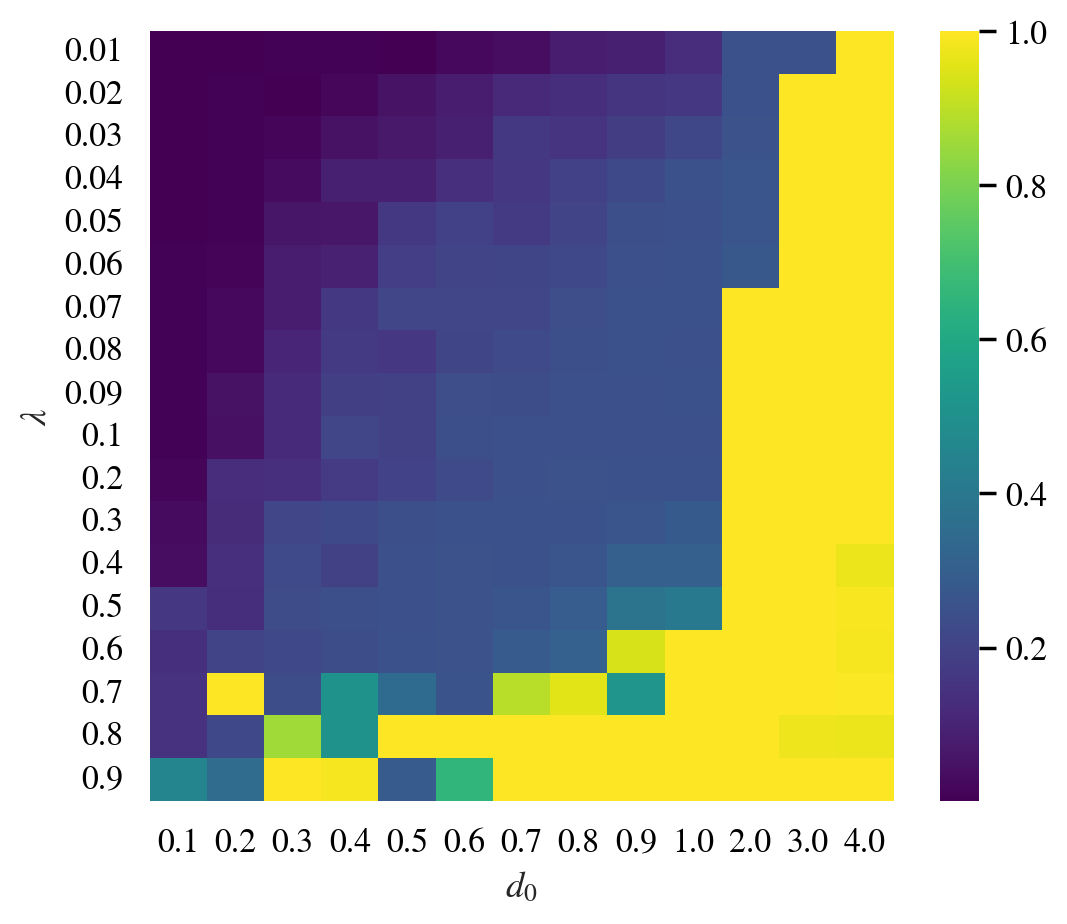

In [30]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    model = SpatialGroups(
        strengthLambda=l, distanceD0=d0, boundaryLength=5, 
        tqdm=False, savePath="./data", randomSeed=10, overWrite=False
    ) 
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    centers = StateAnalysis._calc_centers(lastPositionX, lastPhaseTheta, lastPointTheta, speedV)
    centerRadius = np.sqrt(np.sum((lastPositionX - centers) ** 2, axis=-1))
    omegaTheta = np.abs(model.omegaTheta)
    theryRadius = 3 / omegaTheta
    maps.loc[l, d0] = np.mean(np.abs(centerRadius - theryRadius) / theryRadius)

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
sns.heatmap(maps, cmap="viridis", vmax=1)
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

### 粒子耦合半径内粒子数

Text(40.234375, 0.5, '$\\lambda$')

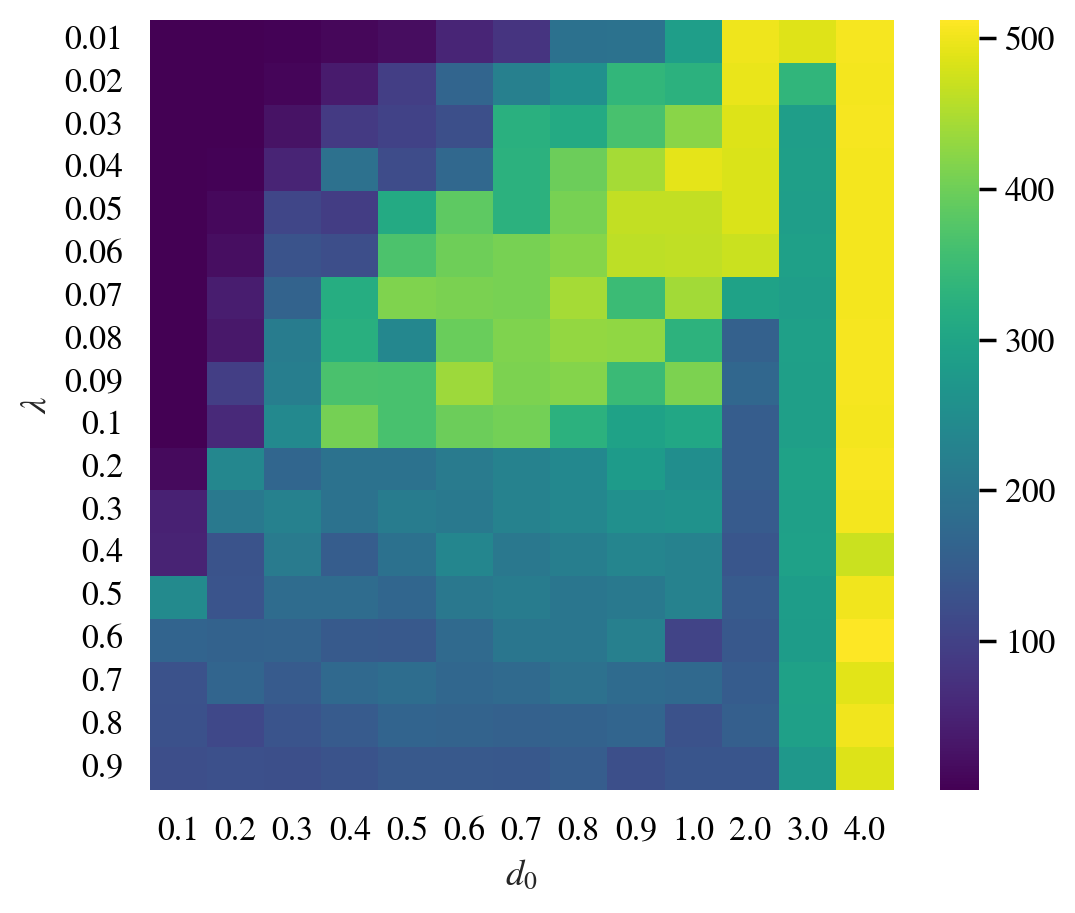

In [37]:
maps = pd.DataFrame(index=rangeLambdas, columns=distanceDs, dtype=np.float64)

for l, d0 in product(rangeLambdas, distanceDs):

    model = SpatialGroups(
        strengthLambda=l, distanceD0=d0, boundaryLength=5, 
        tqdm=False, savePath="./data", randomSeed=10, overWrite=False
    ) 
    lastPositionX = positionX[f"{l:.3f}_{d0:.2f}"]
    lastPhaseTheta = phaseTheta[f"{l:.3f}_{d0:.2f}"]
    lastPointTheta = pointTheta[f"{l:.3f}_{d0:.2f}"]

    deltaX = _delta_x(lastPositionX, lastPositionX[:, np.newaxis])
    distances = np.sqrt(np.sum(deltaX ** 2, axis=-1))

    maps.loc[l, d0] = (distances <= d0).sum(axis=1).mean()

maps.index = np.round(maps.index, 4)
maps.columns = np.round(maps.columns, 4)
sns.heatmap(maps, cmap="viridis")
plt.xlabel(r"$d_0$")
plt.ylabel(r"$\lambda$")

## 时序序参量

### 旋转中心空间分布

In [ ]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_tvcp(models, savePath="./figs/egs/totalXY.png")

### 旋转半径分布

In [3]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_tvcr(models, savePath="./figs/egs/totalRadius.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 旋转中心空间聚集程度1

In [11]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_tvcaop(models, opType=1, savePath="./figs/egs/centerAggOp1_ts.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 旋转中心空间聚集程度2

In [10]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_tvcaop(models, opType=2, savePath="./figs/egs/centerAggOp2_ts.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 旋转中心平均距离分布

In [16]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_tvca(models, opType=1, savePath="./figs/egs/centerAgg1_ts.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 中心距离倒数加权相位同步程度（各粒子）

In [10]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_drpa(models, savePath="./figs/egs/weightedPhaseSync_ts.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 中心距离倒数加权相位同步程度（算数平均）

In [11]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_drpaop(models, savePath="./figs/egs/weightedPhaseSyncOp_ts.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 旋转中心邻域内相位同步程度 (各粒子)

In [4]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_ldpa(models, savePath="./figs/egs/limitDisPhaseSync_ts.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 旋转中心邻域内相位同步程度 (算数平均)

In [4]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_ldpaop(models, savePath="./figs/egs/limitDisPhaseSyncOp_ts.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 聚类数

In [4]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_ccop(models, savePath="./figs/egs/classCountsOp.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 旋转中心邻域内中心数（各粒子）

In [5]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_cnc(models, savePath="./figs/egs/centerNearbyCounts.png")

  0%|          | 0/4 [00:00<?, ?it/s]

### 旋转中心邻域内中心数（算数平均）

In [6]:
models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]
plot_cncop(models, savePath="./figs/egs/centerNearbyCountsOp.png")

  0%|          | 0/4 [00:00<?, ?it/s]

## 相位单位圆

In [3]:
rangeLambdas = np.concatenate([
    np.arange(0.01, 0.1, 0.01),
    np.arange(0.1, 1.1, 0.1)
])
models = [
    SpatialGroups(strengthLambda=l, distanceD0=1, dt=0.01, tqdm=False, savePath="./data") for l in rangeLambdas
]

./data/NoAdjust_uniform_0.009_2.00_40.h5


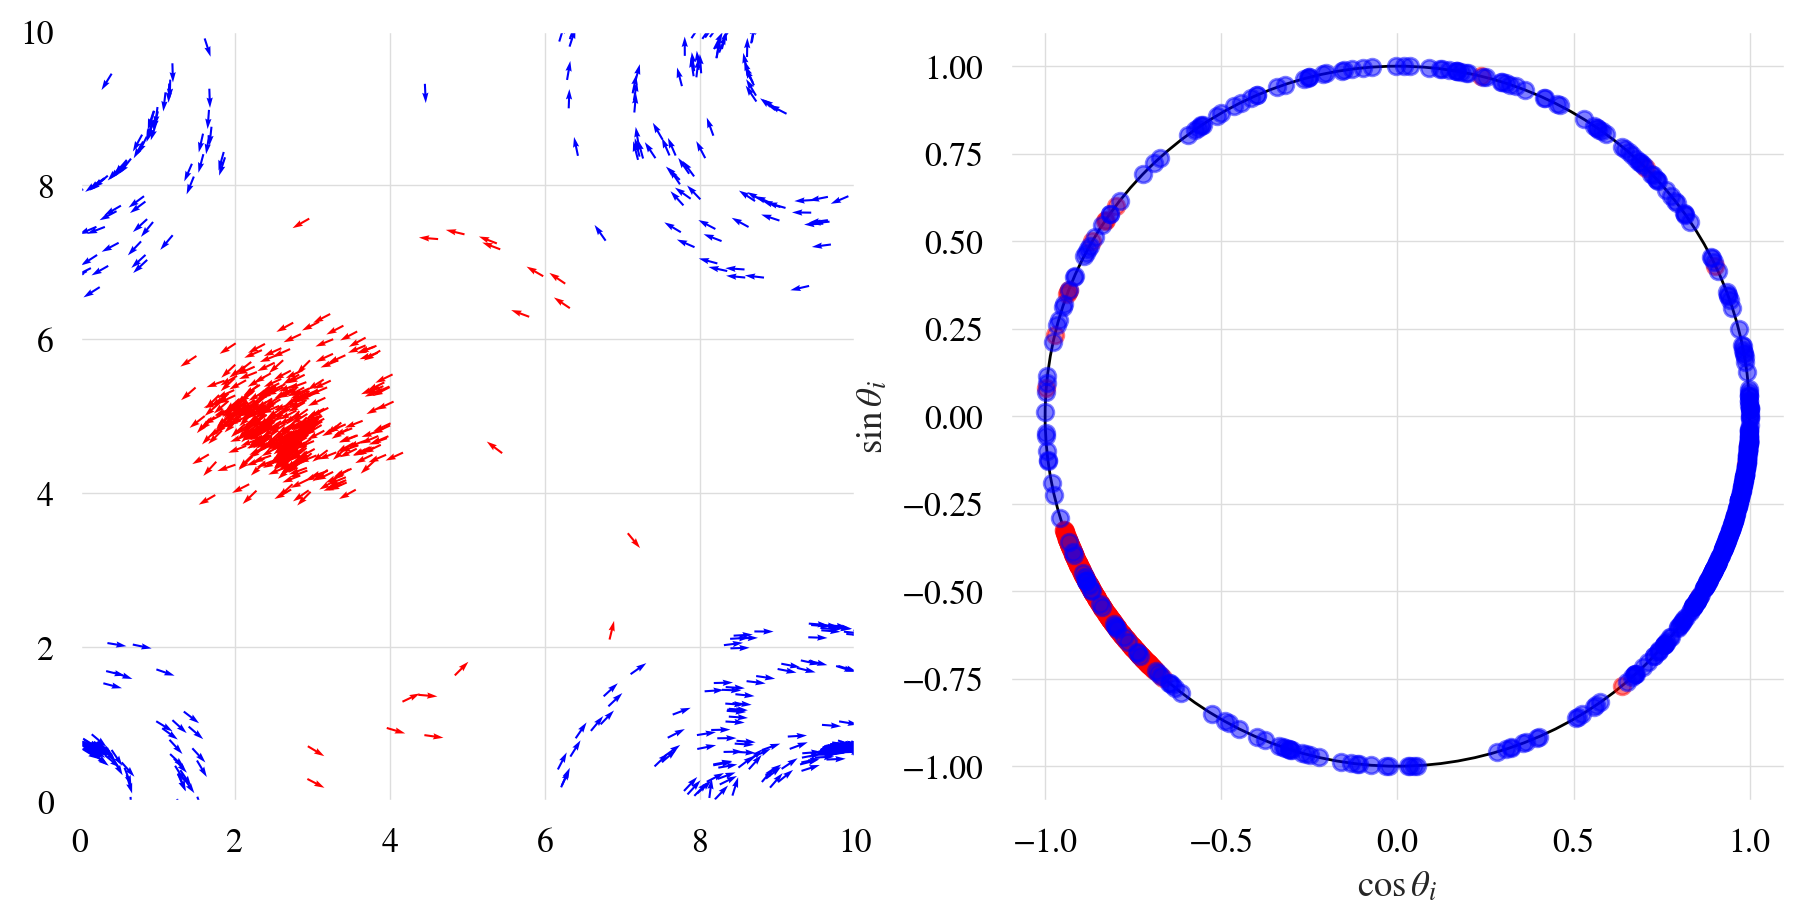

In [17]:
model = SpatialGroups(strengthLambda=0.01, distanceD0=1, dt=0.01, tqdm=True, savePath="./data")

class1, class2 = (
    np.concatenate([np.ones(model.agentsNum // 2), np.zeros(model.agentsNum // 2)]).astype(bool), 
    np.concatenate([np.zeros(model.agentsNum // 2), np.ones(model.agentsNum // 2)]).astype(bool)
)

def plot_last(model):

    targetPath = f"./data/{model}.h5"
    print(targetPath)
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    fig, ax = plt.subplots(figsize=(11, 5))
    plt.title(f"{model}")
    positionX = totalPositionX[-300]
    phaseTheta = totalPhaseTheta[-300]
    # class1, class2 = np.where(pointTheta > 0), np.where(pointTheta < 0)

    ax1 = plt.subplot(1, 2, 1)
    ax1.quiver(
        positionX[class1, 0], positionX[class1, 1],
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='red'
    )
    ax1.quiver(
        positionX[class2, 0], positionX[class2, 1],
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='blue'
    )
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    ax2 = plt.subplot(1, 2, 2)
    circle = plt.Circle((0, 0), 1, color='black', fill=False)
    ax2.add_artist(circle)
    ax2.scatter(
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='red', alpha=0.5
    )
    ax2.scatter(
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='blue', alpha=0.5
    )
    ax2.set_xlim(-1.1, 1.1)
    ax2.set_ylim(-1.1, 1.1)
    ax2.set_xlabel(r"$\cos \theta_i$")
    ax2.set_ylabel(r"$\sin \theta_i$")

    plt.savefig(f"./figs/unitCircle/{model}_2d_circle.png", dpi=200)
    plt.show()

models = [
    # SpatialGroups(strengthLambda=0.05, distanceD0=0.2, savePath="./data", uniform=True, randomSeed=10),
    # SpatialGroups(strengthLambda=0.5, distanceD0=0.1, savePath="./data", uniform=True, randomSeed=10),
    NoAdjust(strengthLambda=0.01, distanceD0=2, savePath="./data", uniform=True, randomSeed=40),
    # SpatialGroups(strengthLambda=0.01, distanceD0=2, savePath="./data", uniform=True, randomSeed=10),
]

for model in models:
    plot_last(model)

In [15]:
targetPath = f"./data/{model}.h5"
# print(targetPath)
totalPositionX = pd.read_hdf(targetPath, key="positionX")
totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
TNum = totalPositionX.shape[0] // model.agentsNum
totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
totalPositionX.shape

(1402, 1000, 2)

In [ ]:
shift = 0

def plot_last(key: str):

    l, d0 = key.split("_")
    l, d0 = float(l), float(d0)
    model = SpatialGroups(strengthLambda=l, distanceD0=d0, dt=0.01, tqdm=False)

    fig, ax = plt.subplots(figsize=(11, 5))
    plt.title(f"{model}")
    lastPositionX = positionX[key]
    lastPhaseTheta = phaseTheta[key]
    # class1, class2 = np.where(pointTheta > 0), np.where(pointTheta < 0)
    
    ax1 = plt.subplot(1, 2, 1)
    ax1.quiver(
        lastPositionX[class1, 0], lastPositionX[class1, 1],
        np.cos(lastPhaseTheta[class1]), np.sin(lastPhaseTheta[class1]), color='tomato'
    )
    ax1.quiver(
        lastPositionX[class2, 0], lastPositionX[class2, 1],
        np.cos(lastPhaseTheta[class2]), np.sin(lastPhaseTheta[class2]), color='dodgerblue'
    )
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    ax2 = plt.subplot(1, 2, 2, projection='3d')
    hist, bins = np.histogram(lastPhaseTheta[class1], bins=100, range=(-np.pi, np.pi))
    # print(np.array([np.zeros_like(hist), hist]).shape)
    ax2.plot_surface(
        np.cos(bins[:-1]), np.sin(bins[:-1]), 
        np.array([np.zeros_like(hist), hist]), 
        color='tomato', alpha=0.5, edgecolor="tomato"
    )
    hist, bins = np.histogram(lastPhaseTheta[class2], bins=100, range=(-np.pi, np.pi))
    ax2.plot_surface(
        np.cos(bins[:-1]) + shift, np.sin(bins[:-1]) + shift,
        np.array([np.zeros_like(hist), hist]), 
        color='dodgerblue', alpha=0.5, edgecolor="dodgerblue"
    )
    ax2.set_xlabel(r"$\cos(\theta_I)$")
    ax2.set_ylabel(r"$\sin(\theta_I)$")

    plt.savefig(f"./figs/unitCircle/{model}.eps", dpi=250)
    plt.close()

for key in tqdm(positionX.keys()):
    plot_last(key)

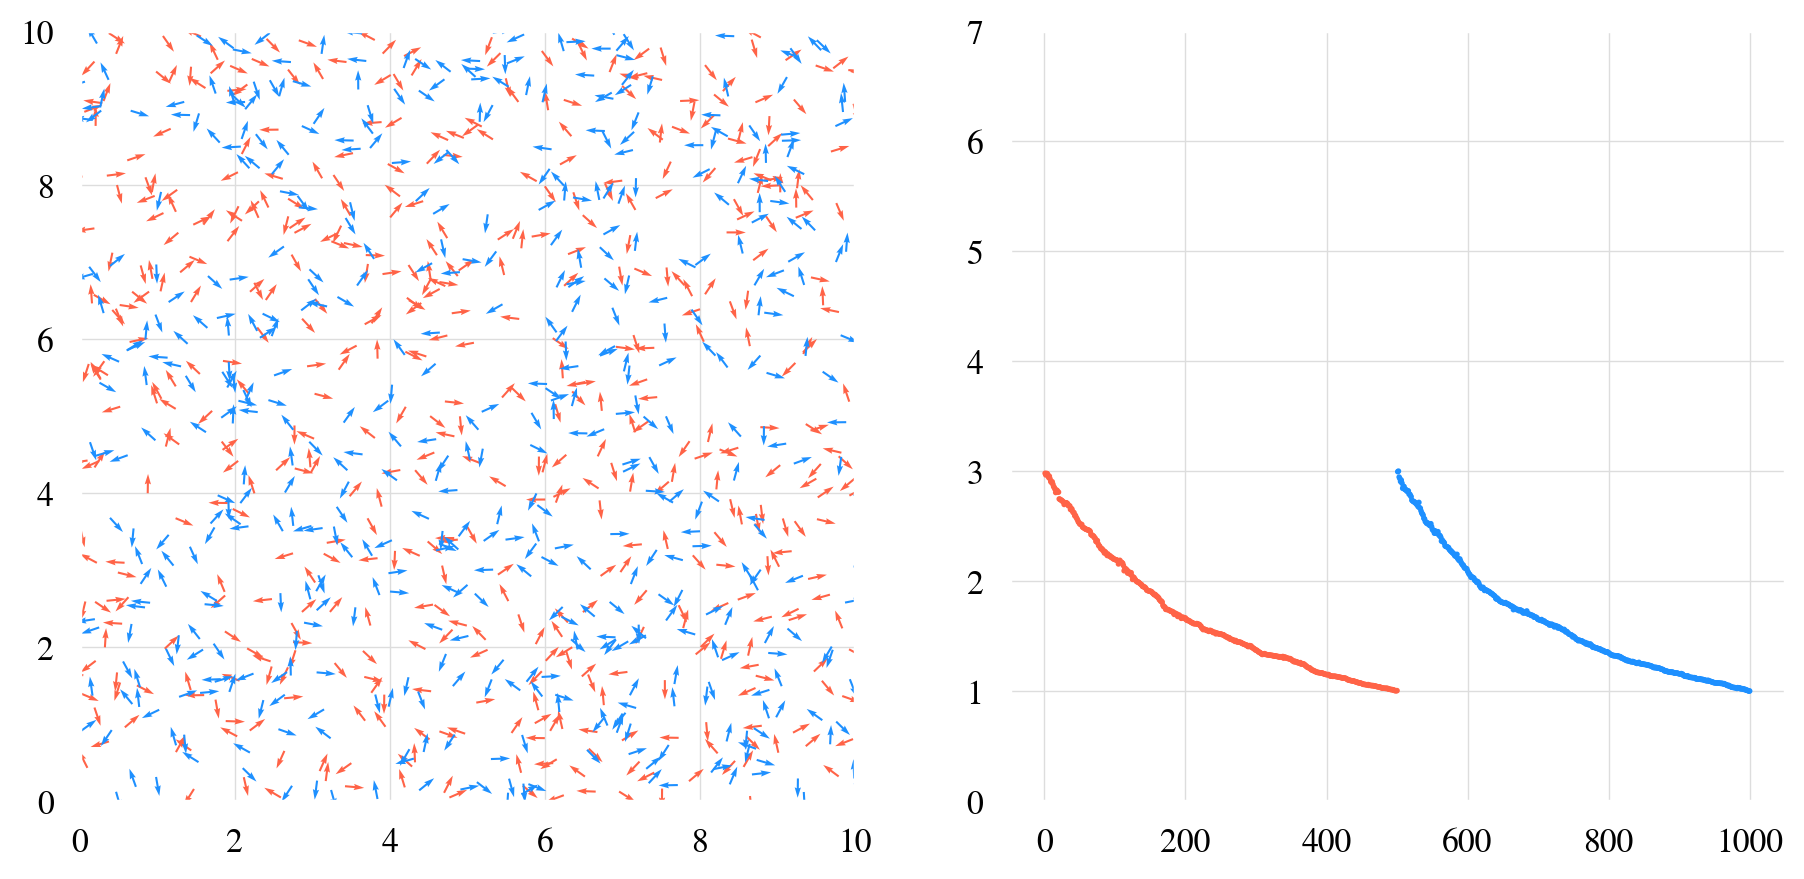

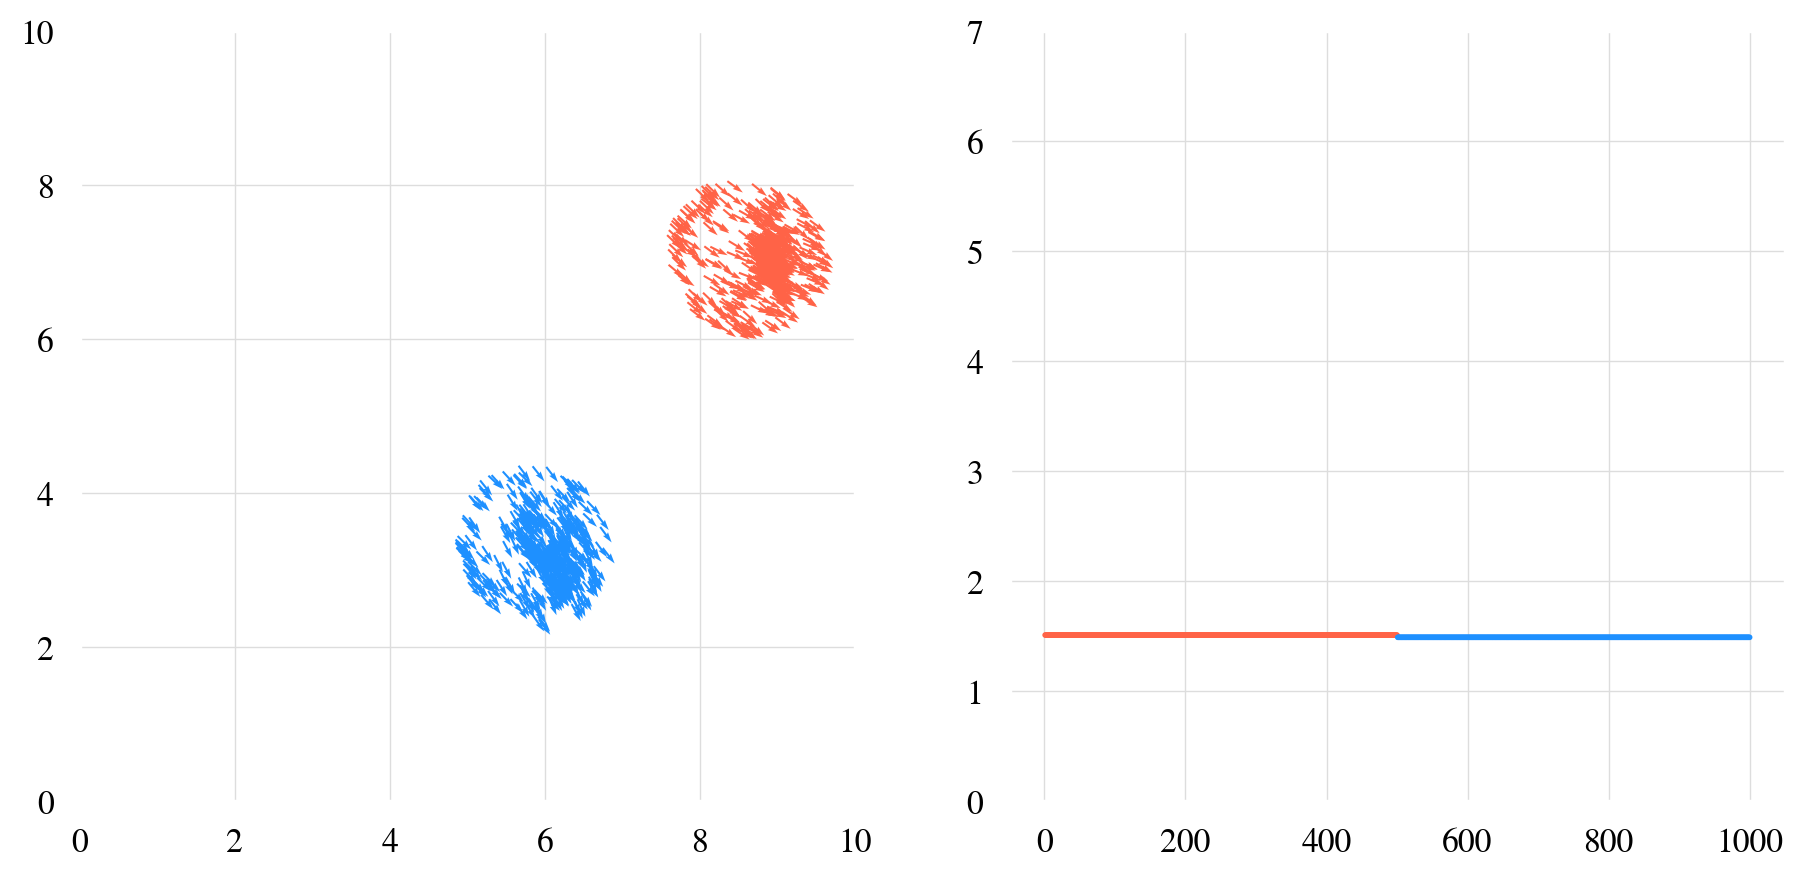

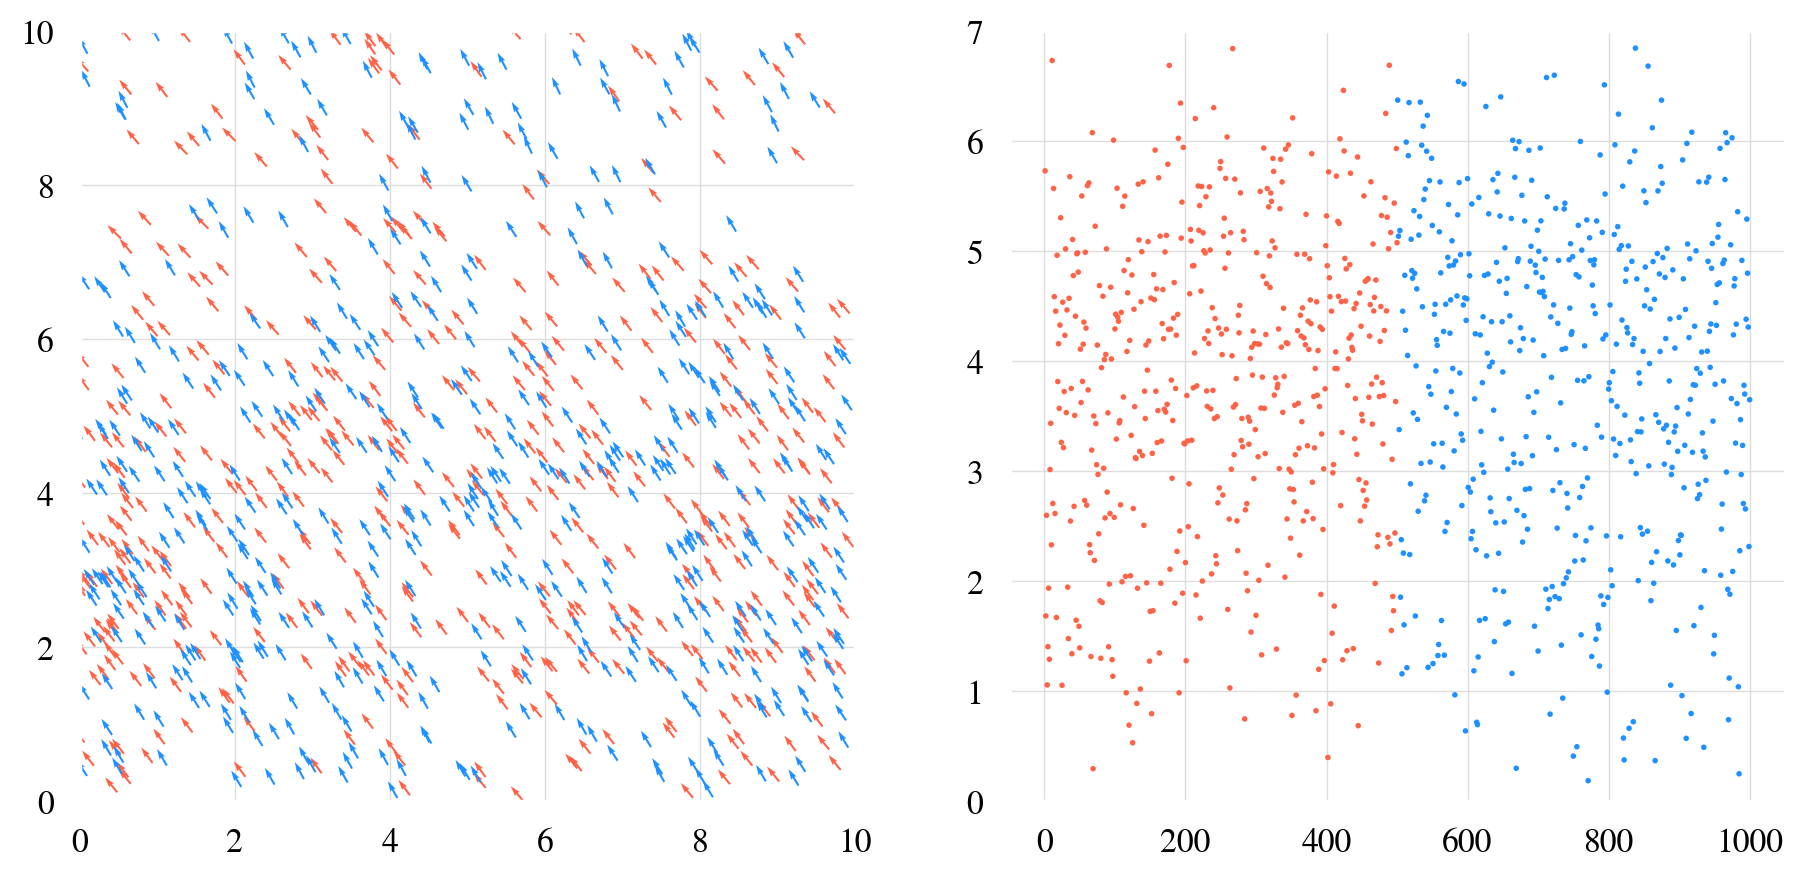

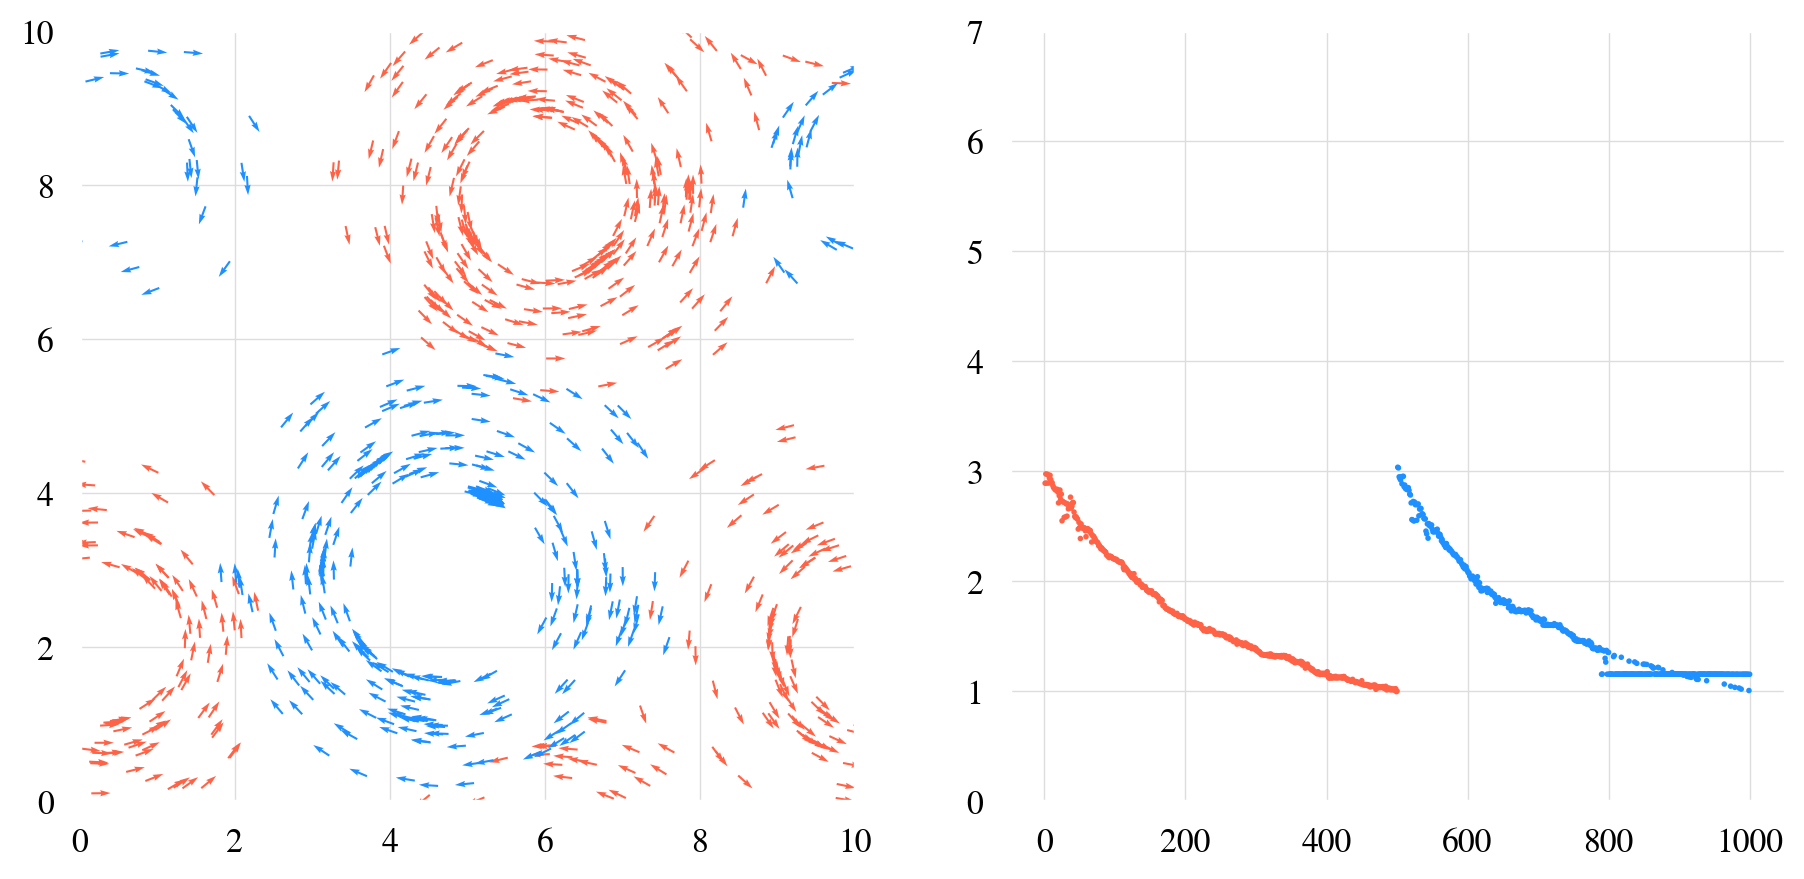

In [15]:
@nb.njit
def _delta_x(positionX, others):
    subX = positionX - others
    adjustOthers = (
        others * (-5 <= subX) * (subX <= 5) + 
        (others - 10) * (subX < -5) + 
        (others + 10) * (subX > 5)
    )
    adjustSubX = positionX - adjustOthers
    return adjustSubX

class1, class2 = (
    np.concatenate([np.ones(model.agentsNum // 2), np.zeros(model.agentsNum // 2)]).astype(bool), 
    np.concatenate([np.zeros(model.agentsNum // 2), np.ones(model.agentsNum // 2)]).astype(bool)
)

def plot_last(model):

    sa = StateAnalysis(model, classDistance=1, lookIndex=-1, tqdm=False)
    positionX, phaseTheta, _ = sa.get_state()
    # class1, class2 = np.where(pointTheta > 0), np.where(pointTheta < 0)

    fig, ax = plt.subplots(figsize=(11, 5))
    ax1 = plt.subplot(1, 2, 1)
    ax1.quiver(
        positionX[class1, 0], positionX[class1, 1],
        np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato'
    )
    ax1.quiver(
        positionX[class2, 0], positionX[class2, 1],
        np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
    )
    ax1.set_xlim(0, 10)
    ax1.set_ylim(0, 10)

    centers = sa.centers
    deltaX = _delta_x(positionX, centers)
    radius = np.sqrt(np.sum(deltaX ** 2, axis=-1))
    omega1 = np.abs(model.omegaTheta[class1])
    omega2 = np.abs(model.omegaTheta[class2])
    omegaIdx = np.concatenate([np.argsort(omega1), np.argsort(omega2) + 500])
    
    ax2 = plt.subplot(1, 2, 2)
    color = ["tomato"] * 500 + ["dodgerblue"] * 500
    ax2.scatter(
        x=np.arange(1, 1001), y=radius[omegaIdx], color=color, s=1
    )
    # ax2.set_xlim(-1.1, 1.1)
    ax2.set_ylim(0, 7)

    plt.savefig(f"./figs/{model}_radius.png", dpi=200)
    plt.show()

models = [
    SpatialGroups(strengthLambda=0.01, distanceD0=0.1, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.01, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.3, distanceD0=2, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
    SpatialGroups(strengthLambda=0.02, distanceD0=0.4, tqdm=False, savePath="./data", uniform=True, randomSeed=10, overWrite=False),
]

for model in models:
    plot_last(model)

In [9]:
def count_intervals(sequence, num_bins):
    min_val = 2 * np.pi
    max_val = 0

    # 使用numpy的histogram函数计算每个区间的计数
    hist, bins = np.histogram(sequence, bins=num_bins, range=(min_val, max_val))

    # 创建每个区间的标签
    labels = []
    for i in range(num_bins):
        labels.append('[{:.2f}, {:.2f})'.format(bins[i], bins[i+1]))

    return dict(zip(labels, hist))

In [27]:
model = SpatialGroups(
    strengthLambda=0, distanceD0=0, dt=0.05,
    savePath="./data", randomSeed=10, tqdm=True, overWrite=True
)
model.run(1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [11]:
sa = StateAnalysis(model)
totalPositionX = sa.totalPositionX
tailPosition = totalPositionX[-500:]
tailPosition.shape

(500, 1000, 2)

In [22]:
AijArray = np.array([
    sa.adj_distance(tailPosition[i], tailPosition[i][:, np.newaxis])
    for i in range(tailPosition.shape[0])
]) <= model.distanceD0

In [26]:
AijArray.mean(axis=0).mean()

0.499995904

In [34]:
def draw_mp4(model):

    targetPath = f"./data/{model}.h5"
    totalPositionX = pd.read_hdf(targetPath, key="positionX")
    totalPhaseTheta = pd.read_hdf(targetPath, key="phaseTheta")
    totalPointTheta = pd.read_hdf(targetPath, key="pointTheta")
    TNum = totalPositionX.shape[0] // model.agentsNum
    totalPositionX = totalPositionX.values.reshape(TNum, model.agentsNum, 2)
    totalPhaseTheta = totalPhaseTheta.values.reshape(TNum, model.agentsNum)
    totalPointTheta = totalPointTheta.values.reshape(TNum, model.agentsNum)
    shift = 0
    class1, class2 = (
        np.concatenate([np.ones(model.agentsNum // 2), np.zeros(model.agentsNum // 2)]).astype(bool), 
        np.concatenate([np.zeros(model.agentsNum // 2), np.ones(model.agentsNum // 2)]).astype(bool)
    )

    def plot_frame(i):
        pbar.update(1)
        positionX = totalPositionX[i]
        phaseTheta = totalPhaseTheta[i]
        fig.clear()
        ax1 = plt.subplot(1, 2, 1)
        ax1.quiver(
            positionX[class1, 0], positionX[class1, 1],
            np.cos(phaseTheta[class1]), np.sin(phaseTheta[class1]), color='tomato'
        )
        ax1.quiver(
            positionX[class2, 0], positionX[class2, 1],
            np.cos(phaseTheta[class2]), np.sin(phaseTheta[class2]), color='dodgerblue'
        )
        ax1.set_xlim(0, 10)
        ax1.set_ylim(0, 10)

        ax2 = plt.subplot(1, 2, 2, projection='3d')
        hist, bins = np.histogram(phaseTheta[class1], bins=100, range=(-np.pi, np.pi))
        # print(np.array([np.zeros_like(hist), hist]).shape)
        ax2.plot_surface(
            np.cos(bins[:-1]), np.sin(bins[:-1]), 
            np.array([np.zeros_like(hist), hist]), 
            color='tomato', alpha=0.5, edgecolor="tomato"
        )
        hist, bins = np.histogram(phaseTheta[class2], bins=100, range=(-np.pi, np.pi))
        ax2.plot_surface(
            np.cos(bins[:-1]) + shift, np.sin(bins[:-1]) + shift,
            np.array([np.zeros_like(hist), hist]), 
            color='dodgerblue', alpha=0.5, edgecolor="dodgerblue"
        )
        ax2.set_xlabel(r"$\cos(\theta_I)$")
        ax2.set_ylabel(r"$\sin(\theta_I)$")
        ax2.set_zlabel("Count")

    mp4TNum = 200
    pbar = tqdm(total=mp4TNum)
    fig, ax = plt.subplots(figsize=(11, 5))
    ani = ma.FuncAnimation(fig, plot_frame, frames=np.arange(0, mp4TNum, 1), interval=100, repeat=False)
    # 编码格式采用H.265
    ani.save(f"./mp4/{model}.mp4", dpi=250, writer="ffmpeg")

    plt.close()

    pbar.close()

draw_mp4(model)

  0%|          | 0/200 [00:00<?, ?it/s]